In [1]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt

In [37]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier


# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [8]:
# Create our features
X = pd.get_dummies(df, columns= ['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type', 'hardship_flag', 'debt_settlement_flag']).drop('loan_status',axis=1)

# Create our target
y = df["loan_status"]

X.head(5)

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1


In [9]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [10]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [15]:
# Scale and Normalize Data
data_scaled=StandardScaler()

# fit and transfor data
X_scaled=data_scaled.fit_transform(X)
#View first row
X_scaled[:1]

array([[-0.60109272,  0.91798436, -0.36555835, -0.1921948 ,  0.27040056,
        -0.30314253, -0.65649151, -0.76165917, -0.37420432, -0.73252183,
        -0.8658573 , -0.58124513, -0.58081958, -0.50046544, -0.50029335,
        -0.3228639 , -0.89960419, -0.03227363,  0.        ,  0.        ,
        -0.17383528, -0.12011247,  0.        ,  0.        , -0.00589695,
        -0.72692228,  1.67997825,  0.2392533 ,  1.19137226,  1.35299632,
        -0.80895603, -0.13418715, -0.45717571, -0.16310175, -0.24864022,
        -0.83203994,  0.12422197, -1.04213361, -0.24758239, -0.59166015,
         0.75578041,  0.37274923, -0.59052419, -0.80915288,  1.04494582,
        -0.07820908, -0.00778953, -0.56994022, -0.7981628 , -0.64845959,
        -0.66313947, -0.8249868 , -0.14674317, -1.10824038, -0.33490355,
        -1.13862411, -1.05103022, -1.27998521, -1.40011594,  0.06599699,
        -1.11347944, -1.31043257, -1.0519437 , -0.75930693,  0.        ,
         0.        , -0.13347217,  0.41138923, -1.1

In [16]:
#Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)


In [18]:
#view ytrain counts
y_train.value_counts()

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [31]:
# Resample the training data with the BalancedRandomForestClassifier
#model
brclf = BalancedRandomForestClassifier(random_state=1, n_estimators = 100)
#filt
brclf=brclf.fit(X_train, y_train)

In [32]:
# Calculated the balanced accuracy score
#predict
y_pred = brclf.predict(X_test)
# Balance accuracy report
balanced_accuracy_score(y_test, y_pred)

0.7837130912576757

In [33]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,70,31
Actual low_risk,2149,14955


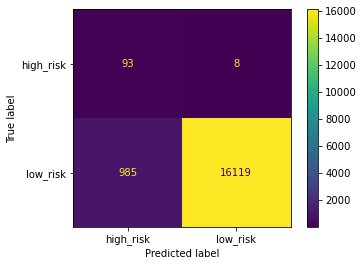

In [47]:
#Display confusion matrix using ConfusinMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=brclf.classes_)
display.plot()

#Save Image
plt.savefig("../Images/BalancedRandomForestClassifier_confusion_matrix.png")
plt.show()

In [35]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))


                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.69      0.87      0.06      0.78      0.60       101
   low_risk       1.00      0.87      0.69      0.93      0.78      0.62     17104

avg / total       0.99      0.87      0.69      0.93      0.78      0.62     17205



In [36]:
# List the features sorted in descending order by feature importance
by_features = sorted(zip(brclf.feature_importances_, X.columns), reverse=True)
for feature_rank in by_features:
    print(f"{feature_rank[1]}: ({feature_rank[0]})")

total_rec_prncp: (0.07876809003486353)
total_pymnt: (0.05883806887524815)
total_pymnt_inv: (0.05625613759225244)
total_rec_int: (0.05355513093134745)
last_pymnt_amnt: (0.0500331813446525)
int_rate: (0.02966959508700077)
issue_d_Jan-2019: (0.021129125328012987)
installment: (0.01980242888931366)
dti: (0.01747062730041245)
out_prncp_inv: (0.016858293184471483)
total_bal_ex_mort: (0.01641297102011915)
mths_since_recent_inq: (0.015220714904737209)
issue_d_Mar-2019: (0.015115240704562424)
revol_bal: (0.014926655663448373)
max_bal_bc: (0.014899352873994727)
out_prncp: (0.014881069023035237)
mo_sin_old_rev_tl_op: (0.014859446582326507)
annual_inc: (0.014832564501144122)
bc_util: (0.014613819728800227)
tot_hi_cred_lim: (0.014487685026878092)
mo_sin_old_il_acct: (0.013921085423763812)
mths_since_rcnt_il: (0.013534131593418711)
total_rev_hi_lim: (0.013364759441576994)
avg_cur_bal: (0.01332289882475225)
bc_open_to_buy: (0.013265926832893358)
il_util: (0.01311545089813887)
total_bc_limit: (0.01304

### Easy Ensemble AdaBoost Classifier

In [38]:
# Train the EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=1, n_estimators = 100)
#fit/train
eec.fit(X_train, y_train) 

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [39]:
# Calculated the balanced accuracy score
#predict
y_pred =eec.predict(X_test)
#Balance Score
balanced_accuracy_score(y_test, y_pred)

0.931601605553446

In [40]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,93,8
Actual low_risk,985,16119


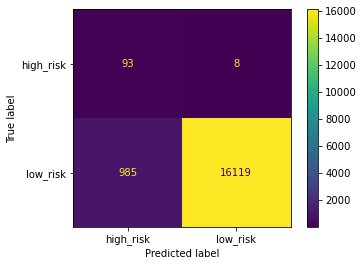

In [46]:
#Display confusion matrix using ConfusinMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=eec.classes_)
display.plot()

#Save Image
plt.savefig("../Images/EasyEnsembleClassifier_confusion_matrix.png")
plt.show()

In [42]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205

